In [1]:
# import google
import collections
import json
import re

import nltk
import numpy as np
import pandas
import pandas as pd

# import torchtext
import PIL.Image
import torch
import torch.nn as nn
import torchvision
from transformers import AutoFeatureExtractor, AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# MOUNT_PATH = '/content/drive'
# DRIVE_PATH = f'{MOUNT_PATH}/My Drive'
# PROJECT_PATH = DRIVE_PATH + "/Assignment 2"
PROJECT_PATH = "./"
IMG_PATH = f"{PROJECT_PATH}/data"
TRAIN_CSV_PATH = f"{PROJECT_PATH}/train.csv"
TEST_CSV_PATH = f"{PROJECT_PATH}/test.csv"

# google.colab.drive.mount(MOUNT_PATH)

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

class FieldTransform(object):
    def __init__(self, field, transform):
        self.field = field
        self.transform = transform

    def __call__(self, sample):
        sample[self.field] = self.transform(sample[self.field])
        return sample

transforms = torchvision.transforms.Compose(
    [
        #   FieldTransform('image', torchvision.transforms.Resize((64, 64))),
        #   FieldTransform('image', torchvision.transforms.CenterCrop(64)),
        FieldTransform("image", torchvision.transforms.Resize((224, 224))),
        FieldTransform("image", torchvision.transforms.ToTensor()),
        FieldTransform("image", normalize),
    ]
)

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.tags = set()
        self.df_data = pd.read_csv(TRAIN_CSV_PATH, names=range(4), skiprows=1)
        self.df_data[0] = IMG_PATH + "/" + self.df_data[0]
        self.df_data[3] = self.df_data[3].fillna("")
        self.df_data[2] += self.df_data[3]
        self.df_data = self.df_data.drop(3, axis=1)
        self.df_data = self.df_data.rename({0: "image", 1: "label", 2: "caption"}, axis=1)

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = PIL.Image.open(self.df_data.iloc[idx, 0])
        label = self.df_data.iloc[idx, 1]
        caption = self.df_data.iloc[idx, 2]

        sample = {"caption": caption, "label": label, "image": image}

        if self.transform:
            sample = self.transform(sample)

        return sample


class TestDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.tags = set()
        self.df_data = pd.read_csv(TEST_CSV_PATH, names=range(3), skiprows=1)
        self.df_data[0] = IMG_PATH + "/" + self.df_data[0]
        self.df_data[2] = self.df_data[2].fillna("")
        self.df_data[1] += self.df_data[2]
        self.df_data = self.df_data.drop(2, axis=1)
        self.df_data = self.df_data.rename({0: "image", 1: "caption"}, axis=1)

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = PIL.Image.open(self.df_data.iloc[idx, 0])
        caption = self.df_data.iloc[idx, 1]

        sample = {"caption": caption, "image": image}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
NUM_ClASSES = 18
import math

import torch.nn as nn


class Combined_Model(torch.nn.Module):
    def __init__(self, visual_features, lang_model):
        super().__init__()
        self.visual_features = visual_features
        self.lang_model = lang_model
        self.proj = nn.Linear(1000, 128)  # (feature.shape, hidden.shape)
        self.scale = math.sqrt(128)
        self.activation = nn.ReLU()
        self.out = nn.Linear(256, NUM_ClASSES)

    def forward(self, images, input_ids, attention_mask):  # requires tokenized captions
        images = self.visual_features(images)
        images = self.proj(images)

        lang_outs = self.lang_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden = lang_outs["last_hidden_state"]

        attention_weights = (
            torch.bmm(hidden, images.unsqueeze(-1)).squeeze(-1) / self.scale
        )  # (batch, seq_len, 1)
        attention_out = torch.bmm(attention_weights.unsqueeze(1), hidden).squeeze(1)

        return self.out(self.activation(torch.cat([images, attention_out], dim=-1)))

model = torch.load("test_model.pt")

/home/ztan/miniconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


# Generate test labels

In [9]:
def test_collate_fn(X):
    # convert [{key: val, ...}, ...]
    # to [key: [val, ...],  ...}
    X = {k: [v[k] for v in X] for k in X[0]}
    X["image"] = torch.stack(X["image"])

    return X


test_data = TestDataset(transform=transforms)
test_dl = torch.utils.data.DataLoader(
    test_data, batch_size=16, shuffle=False, collate_fn=test_collate_fn, num_workers=24,
)

# save predictions
model.eval()
test_preds = []
for i, batch in enumerate(test_dl):
    captions = batch["caption"]
    images = batch["image"].to(DEVICE)
    inputs = tokenizer(
            captions, return_tensors="pt", padding=True, truncation=True, max_length=40
        )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    predictions = model(images, input_ids, attention_mask)
    test_preds.append(predictions.detach().cpu().numpy())

test_preds = np.vstack(test_preds)

def out_logits_to_preds(logits):
    labels = []
    logits = logits > 0
    lables_available = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19])
    for i in range(logits.shape[0]):
        labels.append(list(lables_available[logits[i]]))
    return labels


# lables_available[(test_preds[:10] > 0)]
# {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19}
test_labels = out_logits_to_preds(test_preds)

df_test = pd.read_csv(TEST_CSV_PATH, names=range(3), skiprows=1)
test_labels_str = [" ".join([str(i) for i in labels]) for labels in test_labels]
df_test["Labels"] = test_labels_str
df_test.rename({0: "ImageID"}, axis=1, inplace=True)

df_test[["ImageID", "Labels"]].to_csv("test_predictions.csv", index=False)

# do fking split interval

In [2]:
train_data = TrainDataset(transform=transforms)
# vocabularise_caption(train_data, vocab)

def train_collate_fn(X):
    # convert [{key: val, ...}, ...]
    # to [key: [val, ...],  ...}
    X = {k: [v[k] for v in X] for k in X[0]}
    X["label"] = torch.stack(X["label"])
    X["image"] = torch.stack(X["image"])

    return X


def one_hot_encode_labels(dataset):
    if "one_hot_encoded_labels" not in dataset.tags:
        dataset.df_data["label"] = dataset.df_data["label"].apply(
            lambda l: torch.nn.functional.one_hot(
                torch.tensor([int(i) - 1 if int(i) < 12 else int(i) - 2 for i in l.split(" ")]), 18
            )
            .sum(axis=0)
            .float()
        )

        dataset.tags.add("one_hot_encoded_labels")

one_hot_encode_labels(train_data)

trainds, valds = torch.utils.data.random_split(train_data, [27000, 3000])

train_dl = torch.utils.data.DataLoader(
    trainds, batch_size=64, shuffle=True, collate_fn=train_collate_fn, num_workers=24,
)

val_dl = torch.utils.data.DataLoader(
    valds, batch_size=8, shuffle=False, collate_fn=train_collate_fn, num_workers=24
)


val_outs = []
val_labels = []

model.eval()
for i, batch in enumerate(val_dl):

    captions = batch["caption"]
    images = batch["image"].to(DEVICE)
    labels = batch["label"].to(DEVICE)

    inputs = tokenizer(
        captions, return_tensors="pt", padding=True, truncation=True, max_length=40
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    #         predictions = model(images, captions)
    predictions = model(images, input_ids, attention_mask)

    val_outs.append(predictions.detach().cpu().numpy())
    val_labels.append(labels.detach().cpu().numpy())
val_labels = np.vstack(val_labels)
val_outs = np.vstack(val_outs)

In [3]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true=val_labels, y_pred=1 * (val_outs > 0), average="samples")

In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as pyplot

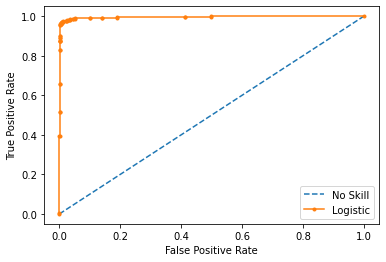

In [14]:
fpr, tpr, thresholds = roc_curve(val_labels[:,2], (val_outs)[:,2])
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [20]:
from numpy import sqrt, argmax
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=-2.820306, G-Mean=0.982
